# Lecture 04 Deep Learning and Backpropagation

## Nueral Network and Backpropagation

In [1]:
import numpy as np

In [2]:
# abstract netural network graph node.

class Node(object):
    """
    Node
    """
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self) # set 'self' node as inbound_node's outbound_nodes

        self.value = None

        # keys are the inputs to this node and their values are partials of this node
        # with respect to that input.
        # \partial{node}{input_i}
        self.gradients = {}

    def forward(self, **kwargs):
        """
        Forward propagation.
        Compute the output value based on 'inbound_nodes' and store the results
        in self.value
        """
        raise  NotImplemented()

    def backward(self):
        """
        Back propagation.
        """
        raise NotImplemented()
        

In [3]:
class Input(Node):
    """
    Input Node.
    """
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        """
        Forward propagation.

        Only input node is the node where the value may be passed as an argument to forward().
        All other node implementation should get value of the previous node from self.inbound[0].value
        """
        if value is not None:
            self.value = value

    def backward(self):
        """
        Back propagation.
        """
        self.gradients = {self: 0}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

In [4]:
class Add(Node):
    """
    Add operation.
    """
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

$$y = w*x + b$$

In [5]:
class Linear(Node):
    """
    Linear Op.
    """
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        """
        Forward propagation.
        y = w*x + b
        """
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias

    def backward(self):
        """
        Backword propagation.
        """
        # initialize a partial for each inbound_nodes.
        self.gradients = { n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

In [6]:
def op_sigmoid(x):
    """
    sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))

$$\sigma'(x) = \sigma * (1 - \sigma)$$

In [7]:
def op_sigmoid_derivative(x):
    """
    sigmoid derivative.
    """
    return op_sigmoid(x) * (1 - op_sigmoid(x))

In [8]:
class Sigmoid(Node):
    """
    Sigmoid Op.
    """
    def __init__(self, node):
        Node.__init__(self, [node])

    def forward(self,):
        """
        Forward propagation.
        """
        self.x = self.inputs[0].value
        self.value = op_sigmoid(self.x)

    def backward(self,):
        """
        Back propagation.
        """
        self.gradients = { n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * op_sigmoid_derivative(self.x)
        

$$L(y, \hat{y}) = \frac{1}{N}\sum{(y - \hat{y})^2}$$

$$\frac{\partial L}{\partial{y}} = \frac{2}{N} \sum{(y - \hat{y})}$$

$$\frac{\partial L}{\partial{\hat{y}}} = -\frac{2}{N} \sum{(y - \hat{y})}$$

In [9]:
class MSE(Node):
    """
    Mean Square Error.
    """
    def __init__(self, y, y_hat):
        Node.__init__(self, [y, y_hat])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        y_hat = self.inputs[1].value.reshape(-1, 1)
        assert y.shape == y_hat.shape

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - y_hat

        self.value = np.mean(self.diff ** 2)

    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


In [10]:
def forward_and_backward(output_node, graph):
    """
    Execute all the forward method of sorted nodes.
    """
    for n in graph:
        n.forward()

    for n in graph[::-1]:
        n.backward()

In [11]:
def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [12]:
def sgd_update(trainables, learning_rate=1e-3):
    """
    Stochastic Grandient Descent.
    """
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

**Dataset**

In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

In [14]:
boston_dataset = load_boston()

In [15]:
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

In [16]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [17]:
boston_dataset.data.shape, boston_dataset.target.shape

((506, 13), (506,))

**Training**

In [18]:
from sklearn.utils import shuffle, resample

In [19]:
dataset = load_boston()

X_ = dataset['data']
Y_ = dataset['target']

# normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1] # feature number
n_hidden = 10  # hidden layer node number


# Initialize W1, b1, W2, b2 paramerters
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural Network
X, Y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(Y, l2)

feed_dict = {
    X: X_,
    Y: Y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 2000

m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, Y_batch = resample(X_, Y_, n_samples=batch_size)
        
        X.value = X_batch
        Y.value = Y_batch

        # forward and backward
        forward_and_backward(None, graph)

        # sgd
        sgd_update(trainables)

        loss += graph[-1].value

    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 0, Loss: 436.427
Epoch: 100, Loss: 19.352
Epoch: 200, Loss: 13.403
Epoch: 300, Loss: 11.375
Epoch: 400, Loss: 9.816
Epoch: 500, Loss: 8.103
Epoch: 600, Loss: 8.236
Epoch: 700, Loss: 7.115
Epoch: 800, Loss: 7.631
Epoch: 900, Loss: 6.565
Epoch: 1000, Loss: 7.251
Epoch: 1100, Loss: 6.546
Epoch: 1200, Loss: 6.384
Epoch: 1300, Loss: 5.656
Epoch: 1400, Loss: 5.789
Epoch: 1500, Loss: 5.381
Epoch: 1600, Loss: 5.192
Epoch: 1700, Loss: 5.553
Epoch: 1800, Loss: 4.946
Epoch: 1900, Loss: 5.355


In [20]:
import matplotlib.pyplot as plt

In [21]:
%matplotlib inline

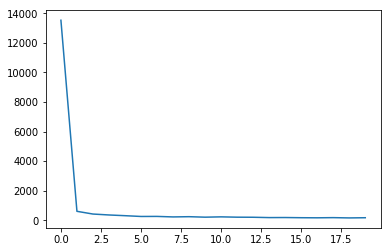

In [22]:
plt.plot(range(len(losses)), losses)

## Keras

In [3]:
pip install tensorflow

  Stored in directory: C:\Users\86186\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Stored in directory: C:\Users\86186\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\86186\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\86186\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
Successfully built opt-einsum gast termcolor absl-py
Note: you may need to restart the kernel to use updated packages.


tensorboard 2.0.1 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.


In [ ]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


Intput:`13` -> Layer1:`40` -> Layer2:`10` -> output: `1`

In [ ]:
model = Sequential()
model.add(Dense(units=40, activation='sigmoid', input_dim=13))
model.add(Dense(units=10, activation='sigmoid', input_dim=40))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [ ]:
# model.fit(X_, Y_, epochs=1000, batch_size=32, verbose=1)